# 04_ocetrac.ipynb
### Use Ocetrac to identify and track MHW objects 


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from ocetrac import model as oce


#### Import SSTA extremes 

In [2]:
file_path_list = ('/burg/abernathey/users/hillary/oisst_v21/positive_extremes_OISSTv21.nc',
                  '/burg/abernathey/users/hillary/oisst_v21/preprocessed_OISSTv21.nc')

ds = xr.open_mfdataset(file_path_list)
ds


<xarray.Dataset>
Dimensions:                     (lat: 720, lon: 1440, time: 478, month: 12)
Coordinates:
  * time                        (time) datetime64[ns] 1981-09-01 ... 2021-06-01
  * lat                         (lat) float32 -89.88 -89.62 ... 89.62 89.88
  * lon                         (lon) float32 0.125 0.375 0.625 ... 359.6 359.9
  * month                       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    lsmask                      (lat, lon) float32 dask.array<chunksize=(720, 1440), meta=np.ndarray>
    ssta_notrend                (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ssta_trend                  (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mean                        (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    trend                       (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    seas                        (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ssta_stn_notrend            (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    prct_notrend                (month, lat, lon) float64 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend            (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino3    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino3_4  (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino4    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
Attributes:
    description:  preprocessed monthly averaged OISST v2.1 anomalies

#### Adjust land mask to ignore points poleward of 65ºN and 70ºS

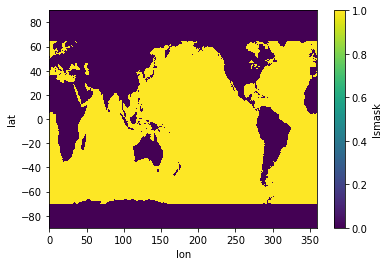

In [3]:
mask = ds.lsmask.where((ds.lat<65) & (ds.lat>-70), drop=False, other=0) 
mask.plot()

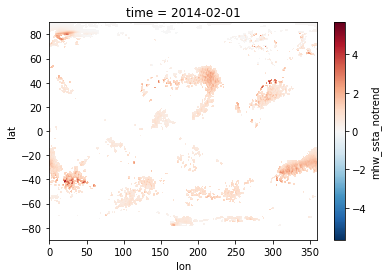

In [4]:
# plot of SSTA that exceeds a predefined threshold (e.g. 90th percentile)
ds.mhw_ssta_notrend.sel(time=('2014-2-01')).plot();

### Run Ocetrac

In [30]:
# Set model parameters
da = ds.mhw_ssta_notrend_noNino4.load() # load the DataArray into memory
radius = 8 # radius for structuring element
min_size_quartile = 0.75 # threshold for object areas
timedim = 'time'
xdim = 'lon'
ydim = 'lat'

In [31]:
Tracker =  oce.Tracker(da, mask, radius, min_size_quartile, timedim, xdim, ydim)


In [32]:
%%time 
blobs = Tracker.track()

minimum area:  2427.5
inital objects identified 	 14443
final objects tracked 	 812
CPU times: user 11min 26s, sys: 3min 46s, total: 15min 13s
Wall time: 15min 21s


**The basic output of `Tracker.track` provides:**
- the minimum object area used to filter out MHWs that are smaller than this threshold. Area is computed for all objects at each time step. `Ocetrac` looks at the global distribution of object area and finds the size that corresponds to a certain percentile defined by `area_quantile`, which can range from 0.0 to 1.0. Larger values for `area_quantile` exclude more MHW objects and will increase the minimum object area threshold. 
- inital features identified have undergone size thresholding, however are not connected in time. 
- final features tracked are the number of unique MHW objects tracked in space and time. 

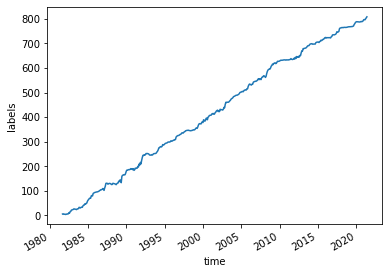

In [33]:
blobs.mean(('lat','lon')).plot()

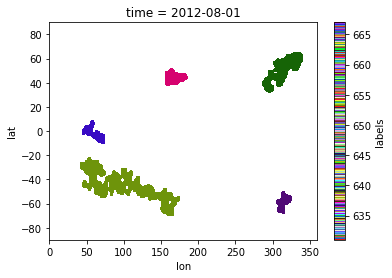

In [34]:
from matplotlib.colors import ListedColormap
maxl = int(np.nanmax(blobs.values))
cm = ListedColormap(np.random.random(size=(maxl, 3)).tolist())


# Make a quick plot of the labeled MHWs identified with Ocetrac
blobs.sel(time=('2012-08-01')).plot(cmap= cm)

### Save tracked labels

In [35]:
# Specify path to save output 
path = '/burg/abernathey/users/hillary/oisst_v21/'

ds_out = blobs.to_dataset(name='ocetrac_labels')
ds_out.attrs['data'] = 'OISST v2.1 notrend noNino4'

# Save Dataset to netCDF
ds_out.to_netcdf(path+'ocetrac_notrend_noNino4.nc', mode='w')


In [36]:
ds_out

<xarray.Dataset>
Dimensions:         (time: 478, lat: 720, lon: 1440)
Coordinates:
  * time            (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
  * lat             (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon             (lon) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    ocetrac_labels  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    data:     OISST v2.1 notrend noNino4